In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
from pandas import MultiIndex, Int64Index

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

import seaborn as sns

import bentoml

C:\Users\daver\miniconda3\envs\tf_gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\daver\AppData\Local\Temp\ipykernel_19204\3548294330.py:12: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
url = "https://raw.githubusercontent.com/DonAvery/health-insurance-cross-sell-prediction/main/data/cleaned-insurance-cross-sell.csv"
df = pd.read_csv(url)

In [3]:
df.head().T

,0,1,2,3,4
id,1,2,3,4,5
gender,male,male,male,male,female
age,44,76,47,21,29
driving_license,1,1,1,1,1
region_code,28.0,3.0,28.0,11.0,41.0
previously_insured,0,0,0,1,1
vehicle_age,g 2 years,1-2 year,g 2 years,l 1 year,l 1 year
vehicle_damage,yes,no,yes,no,no
annual_premium,40454.0,33536.0,38294.0,28619.0,27496.0
policy_sales_channel,26.0,26.0,26.0,152.0,152.0


In [4]:
df_train, df_val = train_test_split(df, test_size=0.2, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = (df_train.response == 'default').astype('int').values
y_val = (df_val.response == 'default').astype('int').values

In [5]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [6]:
y_train = df_train.response.values
y_val = df_val.response.values

In [7]:
del df_train['response']
del df_val['response']

In [8]:
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)

In [9]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)

## One-hot encoding

In [10]:
dv = DictVectorizer(sparse=False)

In [11]:
train_dicts = df_train[categorical + numerical].to_dict('records')
train_dicts[0]

{'gender': 'female',
 'vehicle_age': 'l 1 year',
 'vehicle_damage': 'yes',
 'id': 236272,
 'age': 24,
 'driving_license': 1,
 'region_code': 32.0,
 'previously_insured': 0,
 'annual_premium': 2630.0,
 'policy_sales_channel': 152.0,
 'vintage': 293}

In [12]:
dv.fit(train_dicts)

DictVectorizer(sparse=False)

In [13]:
dv.get_feature_names_out()

array(['age', 'annual_premium', 'driving_license', 'gender=female',
       'gender=male', 'id', 'policy_sales_channel', 'previously_insured',
       'region_code', 'vehicle_age=1-2 year', 'vehicle_age=g 2 years',
       'vehicle_age=l 1 year', 'vehicle_damage=no', 'vehicle_damage=yes',
       'vintage'], dtype=object)

In [14]:
dv.transform(train_dicts)

array([[2.4000e+01, 2.6300e+03, 1.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        2.9300e+02],
       [5.0000e+01, 2.6300e+03, 1.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        3.5000e+01],
       [5.0000e+01, 4.6622e+04, 1.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        1.3200e+02],
       ...,
       [2.2000e+01, 2.4543e+04, 1.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        5.0000e+01],
       [5.9000e+01, 3.3369e+04, 1.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        2.0200e+02],
       [2.4000e+01, 3.9526e+04, 1.0000e+00, ..., 1.0000e+00, 0.0000e+00,
        4.9000e+01]])

In [15]:
train_dicts[11]

{'gender': 'female',
 'vehicle_age': 'l 1 year',
 'vehicle_damage': 'yes',
 'id': 277361,
 'age': 33,
 'driving_license': 1,
 'region_code': 37.0,
 'previously_insured': 0,
 'annual_premium': 49913.0,
 'policy_sales_channel': 152.0,
 'vintage': 100}

In [16]:
X_train = dv.fit_transform(train_dicts)
X_train.shape

(304887, 15)

In [17]:
val_dicts = df_val[categorical + numerical].to_dict('records')
val_dicts[0]

{'gender': 'male',
 'vehicle_age': '1-2 year',
 'vehicle_damage': 'no',
 'id': 61311,
 'age': 68,
 'driving_license': 1,
 'region_code': 28.0,
 'previously_insured': 1,
 'annual_premium': 32788.0,
 'policy_sales_channel': 26.0,
 'vintage': 31}

In [18]:
X_val = dv.transform(val_dicts)
X_val.shape

(76222, 15)

## Logistic Regression model

In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [20]:
model.intercept_[0]

-5.606942723501015e-05

In [21]:
model.coef_[0].round(3)

array([-0.001, -0.   , -0.   , -0.   , -0.   , -0.   , -0.01 , -0.   ,
       -0.001,  0.   ,  0.   , -0.   , -0.   ,  0.   , -0.002])

In [22]:
model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
model.predict_proba(X_train)[:, 1]

array([0.07581975, 0.16231413, 0.08065198, ..., 0.10467964, 0.08514082,
       0.08257692])

In [24]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.31162783, 0.05836764, 0.28120763, ..., 0.11751882, 0.10181066,
       0.06331731])

In [25]:
response_decision = (y_pred >= 0.24)

In [26]:
df_val[response_decision].id

0         61311
2        127953
6         59861
7         70774
9        227733
          ...  
76181    108787
76182     89052
76186     31655
76212     14955
76215     89810
Name: id, Length: 9416, dtype: int64

In [27]:
response_decision.astype(int)

array([1, 0, 1, ..., 0, 0, 0])

In [28]:
(y_val == response_decision).mean()

0.7961349741544436

In [29]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = response_decision.astype(int)
df_pred['actual'] = y_val
df_pred

,probability,prediction,actual
0,0.311628,1,0
1,0.058368,0,0
2,0.281208,1,0
3,0.226036,0,0
4,0.124393,0,0
...,...,...,...
76217,0.071367,0,0
76218,0.087864,0,0
76219,0.117519,0,0
76220,0.101811,0,0


In [30]:
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred

,probability,prediction,actual,correct
0,0.311628,1,0,False
1,0.058368,0,0,True
2,0.281208,1,0,False
3,0.226036,0,0,True
4,0.124393,0,0,True
...,...,...,...,...
76217,0.071367,0,0,True
76218,0.087864,0,0,True
76219,0.117519,0,0,True
76220,0.101811,0,0,True


In [31]:
df_pred.correct.mean()

0.7961349741544436

## Decision Tree

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [34]:
roc_auc_score(y_val, y_pred)

0.6016023338708828

In [35]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [36]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [37]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.8393581667588645
val: 0.8393601353245165


In [38]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (d, auc))

   1 -> 0.770
   2 -> 0.807
   3 -> 0.825
   4 -> 0.834
   5 -> 0.839
   6 -> 0.844
  10 -> 0.851
  15 -> 0.831
  20 -> 0.781
None -> 0.602


In [39]:
for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (m, auc))

1 -> 0.851
5 -> 0.850
10 -> 0.850
15 -> 0.850
20 -> 0.850
50 -> 0.851
100 -> 0.852
200 -> 0.852


In [40]:
for m in [6, 10, 15]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200, 400]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    
    print()

depth: 6
1 -> 0.844
5 -> 0.844
10 -> 0.844
15 -> 0.844
20 -> 0.844
50 -> 0.844
100 -> 0.844
200 -> 0.844
400 -> 0.844

depth: 10
1 -> 0.851
5 -> 0.850
10 -> 0.850
15 -> 0.850
20 -> 0.850
50 -> 0.851
100 -> 0.852
200 -> 0.852
400 -> 0.852

depth: 15
1 -> 0.832
5 -> 0.829
10 -> 0.831
15 -> 0.834
20 -> 0.837
50 -> 0.843
100 -> 0.846
200 -> 0.850
400 -> 0.852



In [41]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.8515818854773937

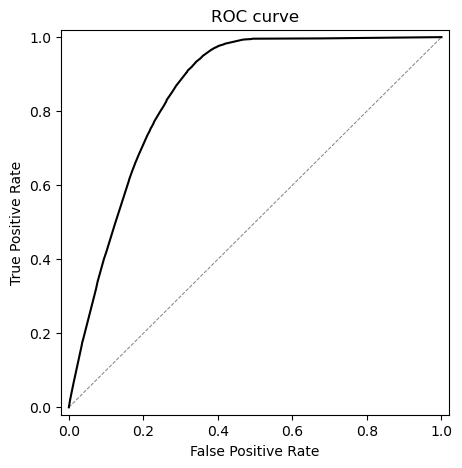

In [42]:
fpr, tpr, _ = roc_curve(y_val, y_pred_dt)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

In [43]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)

## Ensemble and random forest

In [44]:
rf = RandomForestClassifier(n_estimators=10, random_state=11)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7981672958221249

In [45]:
aucs = []

for i in range(100):
    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

print('%.3f +- %.3f' % (auc_mean, auc_std))
print('%.3f -- %.3f' % (auc_mean -  auc_std, auc_mean + auc_std))

0.799 +- 0.002
0.797 -- 0.801


In [46]:
aucs = []

for i in range(130, 151, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=11)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

130 -> 0.840
140 -> 0.841
150 -> 0.841


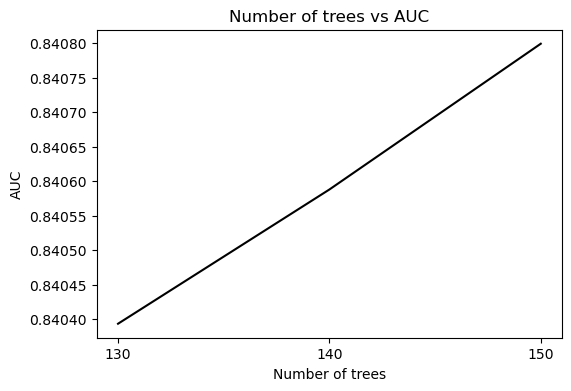

In [47]:
plt.figure(figsize=(6, 4))

plt.plot(range(130, 151, 10), aucs, color='black')
plt.xticks(range(130, 151, 10))

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators.svg')

plt.show()

In [48]:
all_aucs = {}

for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []

    for i in range(130, 151, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=11)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[depth] = aucs
    print()

depth: 5
130 -> 0.849
140 -> 0.849
150 -> 0.849

depth: 10
130 -> 0.855
140 -> 0.855
150 -> 0.855

depth: 20
130 -> 0.852
140 -> 0.852
150 -> 0.853



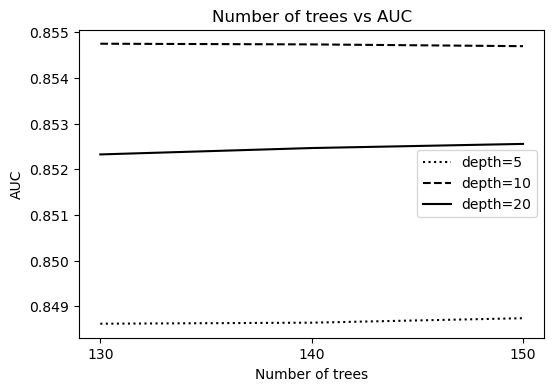

In [49]:
plt.figure(figsize=(6, 4))

num_trees = list(range(130, 151, 10))

plt.plot(num_trees, all_aucs[5], label='depth=5', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[20], label='depth=20', color='black', linestyle='solid')
    
plt.xticks(range(130, 151, 10))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

In [50]:
all_aucs = {}

for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []

    for i in range(130, 151, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=11)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
130 -> 0.855
140 -> 0.855
150 -> 0.855

min_samples_leaf: 5
130 -> 0.855
140 -> 0.855
150 -> 0.855

min_samples_leaf: 10
130 -> 0.855
140 -> 0.855
150 -> 0.855



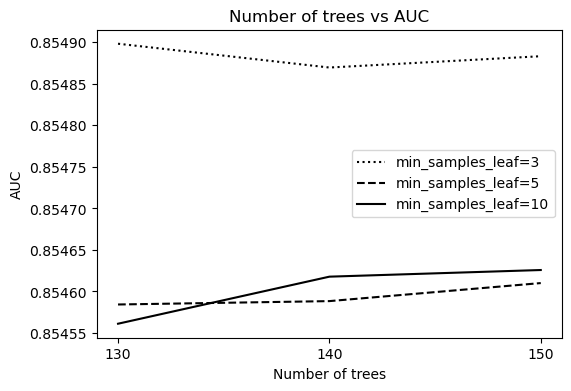

In [51]:
plt.figure(figsize=(6, 4))

num_trees = list(range(130, 151, 10))

plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10', color='black', linestyle='solid')
    
plt.xticks(range(130, 151, 10))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_sample_leaf.svg')

plt.show()

In [52]:
rf = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_leaf=3, random_state=11)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=150,
                       random_state=11)

In [53]:
y_pred_rf = rf.predict_proba(X_val)[:, 1]
random_forest = roc_auc_score(y_val, y_pred_rf)
random_forest

0.8548831125542331

## Gradient boosting and XGBOOST

In [54]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [55]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[04:39:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
y_pred = model.predict(dval)

In [57]:
roc_auc_score(y_val, y_pred)

0.8533610034826781

In [58]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [59]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=10,evals=watchlist)

In [60]:
s = output.stdout

In [61]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [62]:
df_score = parse_xgb_output(output)

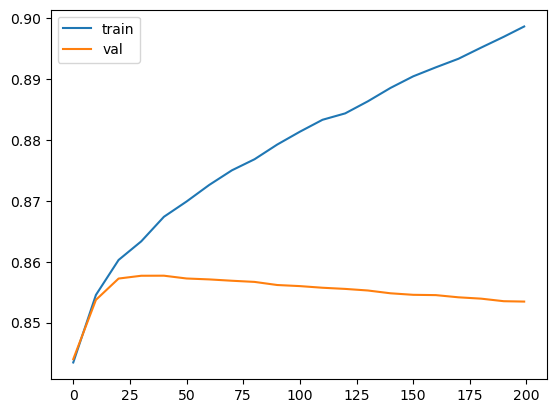

In [63]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [64]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [65]:
tree, aucs_train, aucs_val = parse_xgb_output(output)

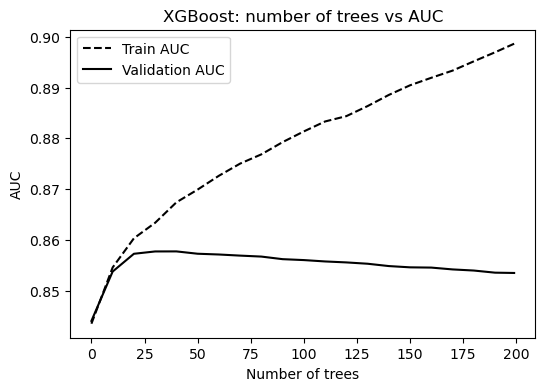

In [66]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_train, color='black', linestyle='dashed', label='Train AUC')
plt.plot(tree, aucs_val, color='black', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 201, 25))

plt.legend()

plt.title('XGBoost: number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_xgb_default.svg')

plt.show()

Let's tune some parameters

In [67]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [68]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.85771
(0.85771, 40)


In [69]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [70]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.85801
(0.85801, 140)


In [71]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [72]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.85792
(0.85792, 290)


In [73]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [74]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.85635
(0.85635, 499)


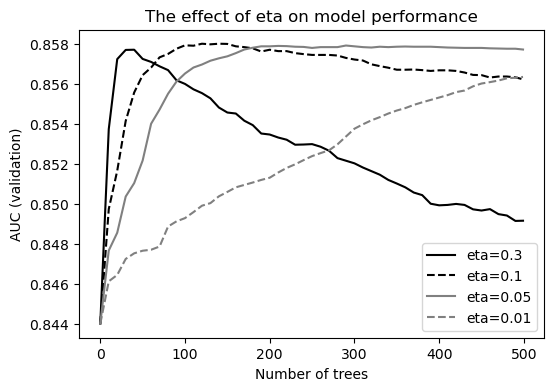

In [75]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, color='grey', linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, color='grey', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_eta.svg')

plt.show()

In [76]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [77]:
tree, _, aucs_val_depth3 = parse_xgb_output(output)
print(max(aucs_val_depth3))
print(max(zip(aucs_val_depth3, tree)))

0.85818
(0.85818, 470)


In [78]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [79]:
tree, _, aucs_val_depth10 = parse_xgb_output(output)
print(max(aucs_val))
print(max(zip(aucs_val_depth10, tree)))

0.85771
(0.85701, 80)


In [80]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 15,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [81]:
tree, _, aucs_val_depth15 = parse_xgb_output(output)
print(max(aucs_val_depth15))
print(max(zip(aucs_val_depth15, tree)))

0.85174
(0.85174, 50)


In [82]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 12,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [83]:
tree, _, aucs_val_depth12 = parse_xgb_output(output)
print(max(aucs_val_depth12))
print(max(zip(aucs_val_depth12, tree)))

0.85567
(0.85567, 50)


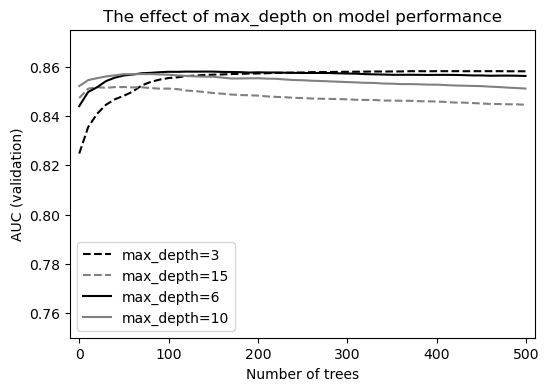

In [84]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_depth3, color='black', linestyle='dashed', label='max_depth=3')
plt.plot(tree, aucs_val_depth15, color='grey', linestyle='dashed', label='max_depth=15')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='solid', label='max_depth=6')
plt.plot(tree, aucs_val_depth10, color='grey', linestyle='solid', label='max_depth=10')

plt.ylim(0.75, 0.875)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of max_depth on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_depth.svg')

plt.show()

In [85]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [86]:
tree, _, aucs_val_mcw1 = parse_xgb_output(output)
print(max(aucs_val_mcw1))
print(max(zip(aucs_val_mcw1, tree)))

0.85818
(0.85818, 470)


In [87]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [88]:
tree, _, aucs_val_mcw10 = parse_xgb_output(output)
print(max(aucs_val_mcw10))
print(max(zip(aucs_val_mcw10, tree)))

0.85806
(0.85806, 410)


In [89]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [90]:
tree, _, aucs_val_mcw30 = parse_xgb_output(output)
print(max(aucs_val_mcw30))
print(max(zip(aucs_val_mcw30, tree)))

0.85828
(0.85828, 460)


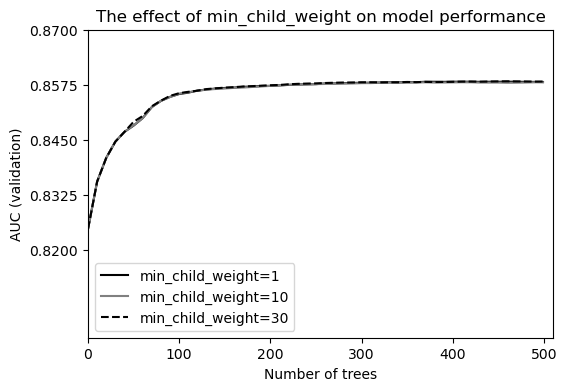

In [91]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_mcw1, color='black', linestyle='solid', label='min_child_weight=1')
plt.plot(tree, aucs_val_mcw10, color='grey', linestyle='solid', label='min_child_weight=10')
plt.plot(tree, aucs_val_mcw30, color='black', linestyle='dashed', label='min_child_weight=30')

plt.ylim(0.80, 0.87)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.82, 0.87, 5))

plt.legend()

plt.title('The effect of min_child_weight on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_mcw.svg')

plt.show()

In [92]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [93]:
print(output)

[0]	train-auc:0.82503	val-auc:0.82474
[10]	train-auc:0.83543	val-auc:0.83549
[20]	train-auc:0.84119	val-auc:0.84089
[30]	train-auc:0.84481	val-auc:0.84457
[40]	train-auc:0.84762	val-auc:0.84679
[50]	train-auc:0.84883	val-auc:0.84821
[60]	train-auc:0.85037	val-auc:0.84993
[70]	train-auc:0.85290	val-auc:0.85243
[80]	train-auc:0.85444	val-auc:0.85383
[90]	train-auc:0.85532	val-auc:0.85475
[100]	train-auc:0.85610	val-auc:0.85539
[110]	train-auc:0.85661	val-auc:0.85570
[120]	train-auc:0.85710	val-auc:0.85617
[130]	train-auc:0.85753	val-auc:0.85640
[140]	train-auc:0.85794	val-auc:0.85664
[150]	train-auc:0.85819	val-auc:0.85676
[160]	train-auc:0.85846	val-auc:0.85684
[170]	train-auc:0.85879	val-auc:0.85702
[180]	train-auc:0.85896	val-auc:0.85708
[190]	train-auc:0.85924	val-auc:0.85721
[200]	train-auc:0.85959	val-auc:0.85724
[210]	train-auc:0.85995	val-auc:0.85735
[220]	train-auc:0.86019	val-auc:0.85746
[230]	train-auc:0.86046	val-auc:0.85754
[240]	train-auc:0.86068	val-auc:0.85759
[250]	train

In [94]:
tree, _, aucs_val = parse_xgb_output(output)
print(max(aucs_val))

0.85818


In [95]:
max(zip(aucs_val, tree))

(0.85818, 470)

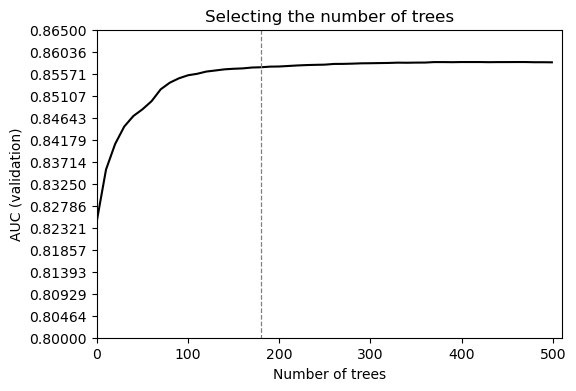

In [96]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val, color='black', linestyle='solid')


plt.ylim(0.80, 0.865)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.80, 0.865, 15))


plt.vlines(180, 0, 1, color='grey', linestyle='dashed', linewidth=0.9)

plt.title('Selecting the number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_number_trees.svg')

plt.show()

In [97]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=470, verbose_eval=10,
                  evals=watchlist)

[0]	train-auc:0.82503	val-auc:0.82474
[10]	train-auc:0.83543	val-auc:0.83549
[20]	train-auc:0.84119	val-auc:0.84089
[30]	train-auc:0.84481	val-auc:0.84457
[40]	train-auc:0.84762	val-auc:0.84679
[50]	train-auc:0.84883	val-auc:0.84821
[60]	train-auc:0.85037	val-auc:0.84993
[70]	train-auc:0.85290	val-auc:0.85243
[80]	train-auc:0.85444	val-auc:0.85383
[90]	train-auc:0.85532	val-auc:0.85475
[100]	train-auc:0.85610	val-auc:0.85539
[110]	train-auc:0.85661	val-auc:0.85570
[120]	train-auc:0.85710	val-auc:0.85617
[130]	train-auc:0.85753	val-auc:0.85640
[140]	train-auc:0.85794	val-auc:0.85664
[150]	train-auc:0.85819	val-auc:0.85676
[160]	train-auc:0.85846	val-auc:0.85684
[170]	train-auc:0.85879	val-auc:0.85702
[180]	train-auc:0.85896	val-auc:0.85708
[190]	train-auc:0.85924	val-auc:0.85721
[200]	train-auc:0.85959	val-auc:0.85724
[210]	train-auc:0.85995	val-auc:0.85735
[220]	train-auc:0.86019	val-auc:0.85746
[230]	train-auc:0.86046	val-auc:0.85754
[240]	train-auc:0.86068	val-auc:0.85759
[250]	train

In [98]:
y_pred_xgb = model.predict(dval)

In [99]:
roc_auc_score(y_val, y_pred_xgb)

0.8580685196185679

In [100]:
print("Decision Tree: ", roc_auc_score(y_val, y_pred_dt))
print("Random Forest: ", roc_auc_score(y_val, y_pred_rf))
print("XGBOOST: ", roc_auc_score(y_val, y_pred_xgb))

Decision Tree:  0.8515818854773937
Random Forest:  0.8548831125542331
XGBOOST:  0.8580685196185679


In [101]:
print("Logistic Regression:", df_pred.correct.mean())

Logistic Regression: 0.7961349741544436
